# Lab 2: Elman Backpropagation Neural Network for Function Approximation

This notebook implements an Elman backpropagation neural network to model a function of two variables. We'll investigate the impact of different network architectures on the average relative error.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable
import time

# Set random seed for reproducibility
np.random.seed(42)


## 1. Define the Function to Model

We'll model the function f(x, y) = x² + y² in the range [0, 10] for both x and y.


In [2]:
def target_function(x: float, y: float) -> float:
    """
    The function we want to model: f(x, y) = x² + y²

    Args:
        x: First input variable
        y: Second input variable

    Returns:
        Function output
    """
    return x**2 + y**2


## 2. Generate Training Data

We'll generate training data by sampling points in the range [0, 10] for both x and y.


Training data shape: X=(10000, 2), y=(10000, 1)
Testing data shape: X=(20, 2), y=(20, 1)


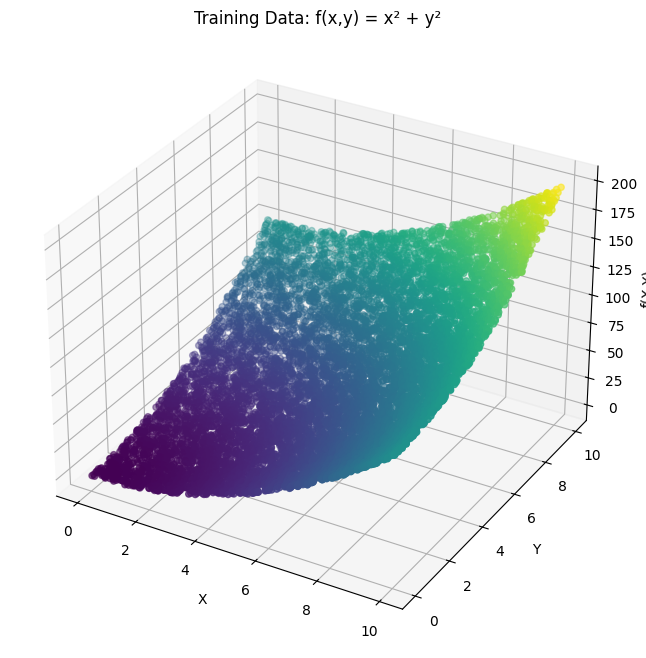

In [3]:
def generate_data(
    func: Callable[[float, float], float], 
    num_samples: int = 10000,
    x_range: Tuple[float, float] = (0, 10), 
    y_range: Tuple[float, float] = (0, 10)
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate training data for a function of two variables.

    Args:
        func: The function to sample
        num_samples: Number of data points to generate
        x_range: Range for x values (min, max)
        y_range: Range for y values (min, max)

    Returns:
        X: Input data of shape (num_samples, 2)
        y: Output data of shape (num_samples, 1)
    """
    # Generate random x and y values within the specified ranges
    X = np.random.uniform(
        low=[x_range[0], y_range[0]], 
        high=[x_range[1], y_range[1]], 
        size=(num_samples, 2)
    )

    # Calculate function values
    y = np.array([func(x_i, y_i) for x_i, y_i in X]).reshape(-1, 1)

    return X, y

# Generate training and testing data
X_train, y_train = generate_data(target_function, num_samples=10000)
X_test, y_test = generate_data(target_function, num_samples=20)

# Normalize the data
X_max = np.max(X_train, axis=0)
y_max = np.max(y_train)

X_train_norm = X_train / X_max
y_train_norm = y_train / y_max
X_test_norm = X_test / X_max
y_test_norm = y_test / y_max

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing data shape: X={X_test.shape}, y={y_test.shape}")

# Plot some sample data points
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:, 0], X_train[:, 1], y_train.flatten(), c=y_train.flatten(), cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X,Y)')
ax.set_title('Training Data: f(x,y) = x² + y²')
plt.show()


## 3. Implement the Elman Backpropagation Neural Network

The Elman network is a type of recurrent neural network that has feedback connections from the hidden layer to a context layer. This context layer stores the previous state of the hidden layer, allowing the network to have a form of memory.


In [4]:
class ElmanNetwork:
    def __init__(
        self, 
        input_size: int, 
        hidden_layers: List[int], 
        output_size: int, 
        learning_rate: float = 0.01
    ):
        """
        Initialize an Elman backpropagation neural network.

        Args:
            input_size: Number of input neurons
            hidden_layers: List containing the number of neurons in each hidden layer
            output_size: Number of output neurons
            learning_rate: Learning rate for weight updates
        """
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize network architecture
        self.num_layers = len(hidden_layers) + 1  # Hidden layers + output layer

        # Initialize weights and biases
        self.weights = []
        self.biases = []

        # Input to first hidden layer weights
        self.weights.append(np.random.randn(input_size, hidden_layers[0]) * 0.1)
        self.biases.append(np.random.randn(hidden_layers[0]) * 0.1)

        # Context to first hidden layer weights (Elman feedback connection)
        self.context_weights = np.random.randn(hidden_layers[0], hidden_layers[0]) * 0.1

        # Hidden layers to hidden layers weights
        for i in range(1, len(hidden_layers)):
            self.weights.append(np.random.randn(hidden_layers[i-1], hidden_layers[i]) * 0.1)
            self.biases.append(np.random.randn(hidden_layers[i]) * 0.1)

        # Last hidden layer to output layer weights
        self.weights.append(np.random.randn(hidden_layers[-1], output_size) * 0.1)
        self.biases.append(np.random.randn(output_size) * 0.1)

        # Initialize context layer (Elman network's memory)
        self.context = np.zeros(hidden_layers[0])

        # For storing training history
        self.error_history = []

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x: np.ndarray) -> np.ndarray:
        """Derivative of sigmoid function"""
        return x * (1 - x)

    def forward(self, X: np.ndarray) -> Tuple[List[np.ndarray], np.ndarray]:
        """
        Forward pass through the network.

        Args:
            X: Input data of shape (input_size,)

        Returns:
            layer_outputs: List of outputs from each layer
            prediction: Final output from the network
        """
        # Store outputs from each layer
        layer_outputs = []

        # Input to first hidden layer + context layer influence
        hidden_input = np.dot(X, self.weights[0]) + self.biases[0] + np.dot(self.context, self.context_weights)
        hidden_output = self.sigmoid(hidden_input)
        layer_outputs.append(hidden_output)

        # Update context layer with current hidden layer output
        self.context = hidden_output.copy()

        # Process through remaining hidden layers
        for i in range(1, len(self.hidden_layers)):
            hidden_input = np.dot(layer_outputs[-1], self.weights[i]) + self.biases[i]
            hidden_output = self.sigmoid(hidden_input)
            layer_outputs.append(hidden_output)

        # Output layer
        output_input = np.dot(layer_outputs[-1], self.weights[-1]) + self.biases[-1]
        prediction = self.sigmoid(output_input)

        return layer_outputs, prediction

    def backward(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        layer_outputs: List[np.ndarray], 
        prediction: np.ndarray
    ) -> None:
        """
        Backward pass to update weights using backpropagation.

        Args:
            X: Input data
            y: Target output
            layer_outputs: Outputs from each layer from forward pass
            prediction: Final output from the network
        """
        # Calculate output layer error
        output_error = y - prediction
        output_delta = output_error * self.sigmoid_derivative(prediction)

        # Initialize list to store deltas for each layer
        deltas = [output_delta]

        # Backpropagate the error through hidden layers
        for i in range(len(self.hidden_layers) - 1, -1, -1):
            if i == len(self.hidden_layers) - 1:
                # Last hidden layer to output layer
                error = output_delta.dot(self.weights[i+1].T)
            else:
                # Hidden layer to hidden layer
                error = deltas[0].dot(self.weights[i+1].T)

            delta = error * self.sigmoid_derivative(layer_outputs[i])
            deltas.insert(0, delta)

        # Update weights and biases
        # First hidden layer weights (from input)
        self.weights[0] += self.learning_rate * np.outer(X, deltas[0])
        self.biases[0] += self.learning_rate * deltas[0]

        # Context weights (Elman recurrent connection)
        self.context_weights += self.learning_rate * np.outer(self.context, deltas[0])

        # Remaining hidden layers and output layer
        for i in range(1, len(self.weights)):
            self.weights[i] += self.learning_rate * np.outer(layer_outputs[i-1], deltas[i])
            self.biases[i] += self.learning_rate * deltas[i]

    def train(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        epochs: int = 1000, 
        batch_size: int = 32, 
        verbose: bool = True
    ) -> List[float]:
        """
        Train the network on the given data.

        Args:
            X: Training inputs of shape (num_samples, input_size)
            y: Training targets of shape (num_samples, output_size)
            epochs: Number of training epochs
            batch_size: Size of mini-batches
            verbose: Whether to print progress

        Returns:
            error_history: List of mean squared errors for each epoch
        """
        num_samples = X.shape[0]
        self.error_history = []

        for epoch in range(epochs):
            epoch_errors = []

            # Shuffle the data
            indices = np.random.permutation(num_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Mini-batch training
            for i in range(0, num_samples, batch_size):
                batch_X = X_shuffled[i:i+batch_size]
                batch_y = y_shuffled[i:i+batch_size]

                batch_errors = []

                for j in range(len(batch_X)):
                    # Reset context for each new sequence
                    if j == 0:
                        self.context = np.zeros(self.hidden_layers[0])

                    # Forward pass
                    layer_outputs, prediction = self.forward(batch_X[j])

                    # Calculate error
                    error = np.mean((batch_y[j] - prediction) ** 2)
                    batch_errors.append(error)

                    # Backward pass
                    self.backward(batch_X[j], batch_y[j], layer_outputs, prediction)

                epoch_errors.extend(batch_errors)

            # Calculate mean error for the epoch
            mean_error = np.mean(epoch_errors)
            self.error_history.append(mean_error)

            # Print progress
            if verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Error: {mean_error:.6f}")

        return self.error_history

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions for the given inputs.

        Args:
            X: Input data of shape (num_samples, input_size)

        Returns:
            predictions: Predicted outputs of shape (num_samples, output_size)
        """
        predictions = np.zeros((X.shape[0], self.output_size))

        for i in range(X.shape[0]):
            # Reset context for each new prediction
            self.context = np.zeros(self.hidden_layers[0])

            # Forward pass
            _, prediction = self.forward(X[i])
            predictions[i] = prediction

        return predictions

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
        """
        Evaluate the network on test data.

        Args:
            X: Test inputs of shape (num_samples, input_size)
            y: Test targets of shape (num_samples, output_size)

        Returns:
            mse: Mean squared error
            mae: Mean absolute error
        """
        predictions = self.predict(X)
        mse = np.mean((y - predictions) ** 2)
        mae = np.mean(np.abs(y - predictions))

        return mse, mae


## 4. Train and Evaluate the Networks

We'll train and evaluate two Elman network configurations:
1. 1 hidden layer with 15 neurons
2. 3 hidden layers with 5 neurons each


In [5]:
# Configuration 1: 1 hidden layer with 15 neurons
print("Training Configuration 1: 1 hidden layer with 15 neurons")
start_time = time.time()

network1 = ElmanNetwork(
    input_size=2,
    hidden_layers=[15],
    output_size=1,
    learning_rate=0.01
)

error_history1 = network1.train(
    X=X_train_norm, 
    y=y_train_norm, 
    epochs=1000, 
    batch_size=32, 
    verbose=True
)

training_time1 = time.time() - start_time
print(f"Training completed in {training_time1:.2f} seconds")

# Evaluate on test data
mse1, mae1 = network1.evaluate(X_test_norm, y_test_norm)
print(f"Test MSE: {mse1:.6f}, MAE: {mae1:.6f}")

# Calculate relative error
predictions1 = network1.predict(X_test_norm) * y_max
relative_error1 = np.mean(np.abs((y_test - predictions1) / y_test)) * 100
print(f"Average Relative Error: {relative_error1:.2f}%")


Training Configuration 1: 1 hidden layer with 15 neurons
Epoch 100/1000, Error: 0.003915
Epoch 200/1000, Error: 0.004461
Epoch 300/1000, Error: 0.006843
Epoch 400/1000, Error: 0.005567
Epoch 500/1000, Error: 0.010555
Epoch 600/1000, Error: 0.012948
Epoch 700/1000, Error: 0.007293
Epoch 800/1000, Error: 0.019476
Epoch 900/1000, Error: 0.011394
Epoch 1000/1000, Error: 0.009049
Training completed in 575.31 seconds
Test MSE: 0.059379, MAE: 0.226265
Average Relative Error: 210.77%


In [6]:
# Configuration 2: 3 hidden layers with 5 neurons each
print("Training Configuration 2: 3 hidden layers with 5 neurons each")
start_time = time.time()

network2 = ElmanNetwork(
    input_size=2,
    hidden_layers=[5, 5, 5],
    output_size=1,
    learning_rate=0.01
)

error_history2 = network2.train(
    X=X_train_norm, 
    y=y_train_norm, 
    epochs=1000, 
    batch_size=32, 
    verbose=True
)

training_time2 = time.time() - start_time
print(f"Training completed in {training_time2:.2f} seconds")

# Evaluate on test data
mse2, mae2 = network2.evaluate(X_test_norm, y_test_norm)
print(f"Test MSE: {mse2:.6f}, MAE: {mae2:.6f}")

# Calculate relative error
predictions2 = network2.predict(X_test_norm) * y_max
relative_error2 = np.mean(np.abs((y_test - predictions2) / y_test)) * 100
print(f"Average Relative Error: {relative_error2:.2f}%")


Training Configuration 2: 3 hidden layers with 5 neurons each
Epoch 100/1000, Error: 0.044939
Epoch 200/1000, Error: 0.044941
Epoch 300/1000, Error: 0.044939
Epoch 400/1000, Error: 0.044941
Epoch 500/1000, Error: 0.044908
Epoch 600/1000, Error: 0.044911
Epoch 700/1000, Error: 0.043379
Epoch 800/1000, Error: 0.004859
Epoch 900/1000, Error: 0.005776
Epoch 1000/1000, Error: 0.010426
Training completed in 2047.10 seconds
Test MSE: 0.049273, MAE: 0.208419
Average Relative Error: 151.79%


## 5. Visualize Results

Let's plot the error vs. epoch graphs for both configurations and compare their performance.


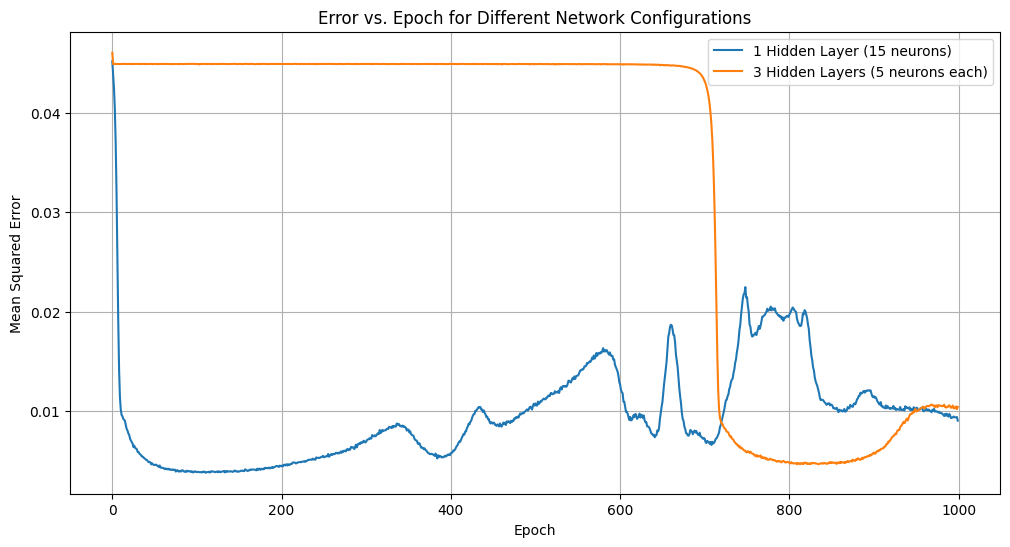

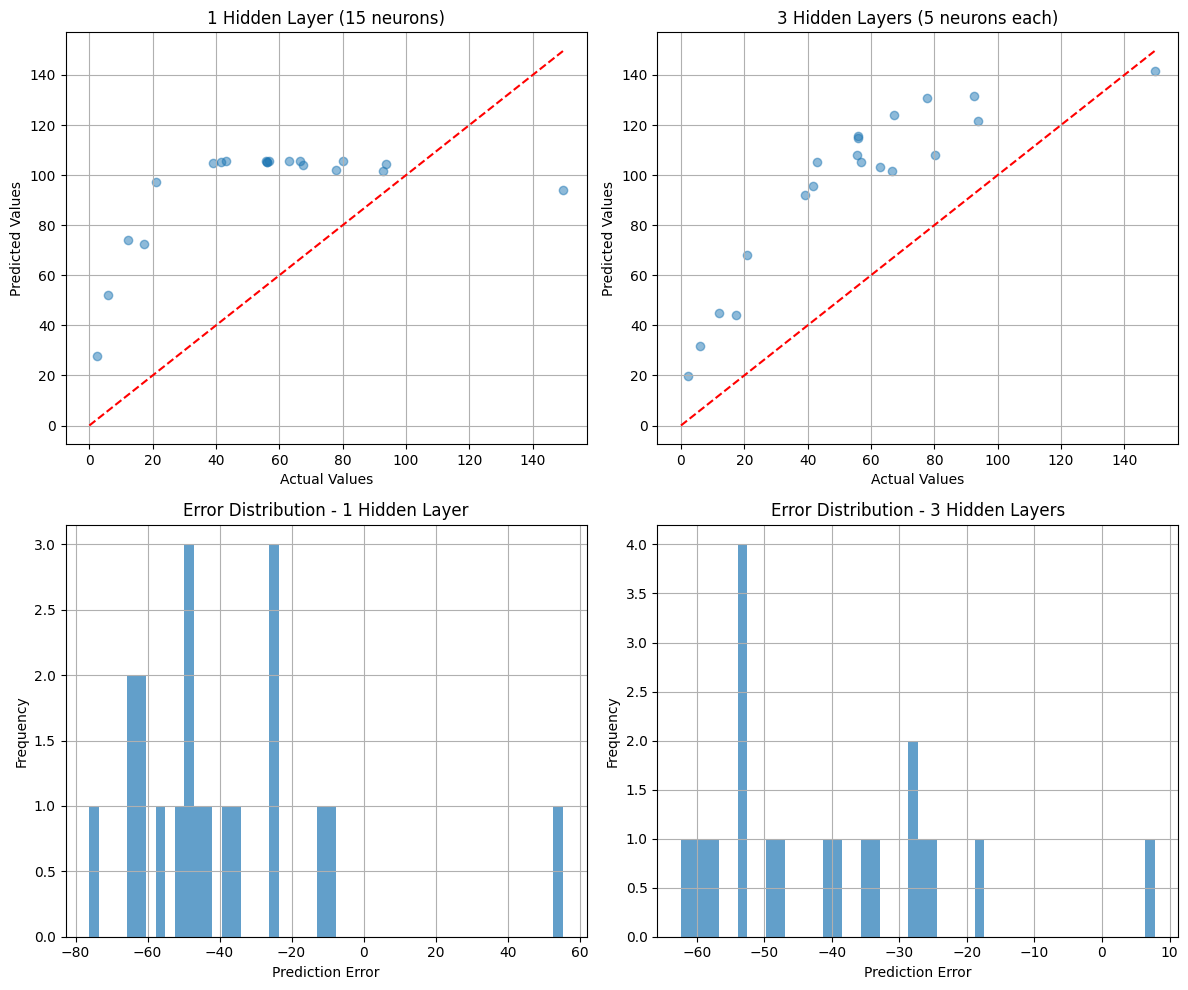

In [7]:
# Plot error vs. epoch for both configurations
plt.figure(figsize=(12, 6))
plt.plot(error_history1, label='1 Hidden Layer (15 neurons)')
plt.plot(error_history2, label='3 Hidden Layers (5 neurons each)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Error vs. Epoch for Different Network Configurations')
plt.legend()
plt.grid(True)
plt.show()

# Compare predictions with actual values
plt.figure(figsize=(12, 10))

# Configuration 1
plt.subplot(2, 2, 1)
plt.scatter(y_test, predictions1, alpha=0.5)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('1 Hidden Layer (15 neurons)')
plt.grid(True)

# Configuration 2
plt.subplot(2, 2, 2)
plt.scatter(y_test, predictions2, alpha=0.5)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('3 Hidden Layers (5 neurons each)')
plt.grid(True)

# Error distribution for Configuration 1
plt.subplot(2, 2, 3)
errors1 = y_test - predictions1
plt.hist(errors1, bins=50, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution - 1 Hidden Layer')
plt.grid(True)

# Error distribution for Configuration 2
plt.subplot(2, 2, 4)
errors2 = y_test - predictions2
plt.hist(errors2, bins=50, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution - 3 Hidden Layers')
plt.grid(True)

plt.tight_layout()
plt.show()


## 6. Summary and Comparison

Let's summarize the performance of both network configurations:


In [8]:
# Create a summary table
print("Performance Comparison:")
print("-" * 80)
print(f"{'Configuration':<30} | {'MSE':<10} | {'MAE':<10} | {'Rel. Error':<15} | {'Training Time':<15}")
print("-" * 80)
print(f"{'1 Hidden Layer (15 neurons)':<30} | {mse1:<10.6f} | {mae1:<10.6f} | {relative_error1:<15.2f}% | {training_time1:<15.2f}s")
print(f"{'3 Hidden Layers (5 neurons each)':<30} | {mse2:<10.6f} | {mae2:<10.6f} | {relative_error2:<15.2f}% | {training_time2:<15.2f}s")
print("-" * 80)

# Determine which configuration performed better
if relative_error1 < relative_error2:
    better_config = "1 Hidden Layer (15 neurons)"
    improvement = (relative_error2 - relative_error1) / relative_error2 * 100
else:
    better_config = "3 Hidden Layers (5 neurons each)"
    improvement = (relative_error1 - relative_error2) / relative_error1 * 100

print(f"\nConclusion: {better_config} performed better with {improvement:.2f}% lower relative error.")
print(f"This suggests that {'fewer layers with more neurons' if better_config == '1 Hidden Layer (15 neurons)' else 'more layers with fewer neurons'} is more effective for this particular function approximation task.")


Performance Comparison:
--------------------------------------------------------------------------------
Configuration                  | MSE        | MAE        | Rel. Error      | Training Time  
--------------------------------------------------------------------------------
1 Hidden Layer (15 neurons)    | 0.059379   | 0.226265   | 210.77         % | 575.31         s
3 Hidden Layers (5 neurons each) | 0.049273   | 0.208419   | 151.79         % | 2047.10        s
--------------------------------------------------------------------------------

Conclusion: 3 Hidden Layers (5 neurons each) performed better with 27.98% lower relative error.
This suggests that more layers with fewer neurons is more effective for this particular function approximation task.
